# DBSCAM
This notebook applies DBSCAN clustering to the three datasets contained in `../final/`. All of them contains information about the GDP and the CO2 emissions for each country, however, they are divided as:
- Every country (with time series) 
- European countries

## Step 0: Import and Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
os.makedirs('../plots/dbscan', exist_ok=True)

In [2]:
df = pd.read_csv('../data/final/gdp_co2_emissions.csv')
df.drop(columns=['Country Code', 'CO2 emissions', 'GDP growth (annual %)', 'GDP'], inplace=True)
df.head()

,Country Name,Continent,Year,CO2 emissions per capita,GDP per capita,log (GDP pc),log (CO2 pc)
0,Afghanistan,Asia,2000,0.052017,1617.826475,7.388839,-2.956177
1,Afghanistan,Asia,2001,0.052706,1454.110782,7.282150,-2.943032
2,Afghanistan,Asia,2002,0.062731,1774.308743,7.481166,-2.768904
3,Afghanistan,Asia,2003,0.068608,1815.928200,7.504352,-2.679340
4,Afghanistan,Asia,2004,0.052513,1776.918207,7.482636,-2.946689


 ---
## 1. Apply DBSCAN

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

num_ranges = 3
min_year = df['Year'].min()
max_year = df['Year'].max()
print(f"Data covers years from {min_year} to {max_year}")

Data covers years from 1990 to 2024


In [4]:
def dbscan_clustering(df, cols, eps=0.5, min_samples=5, results_col_name='Cluster'):
    cluster_assignments = []
    
    X = df[cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_assignments = dbscan.fit_predict(X_scaled)
    
    df[results_col_name] = cluster_assignments.astype(int)
    return df

### 1.0 K-distance Plots

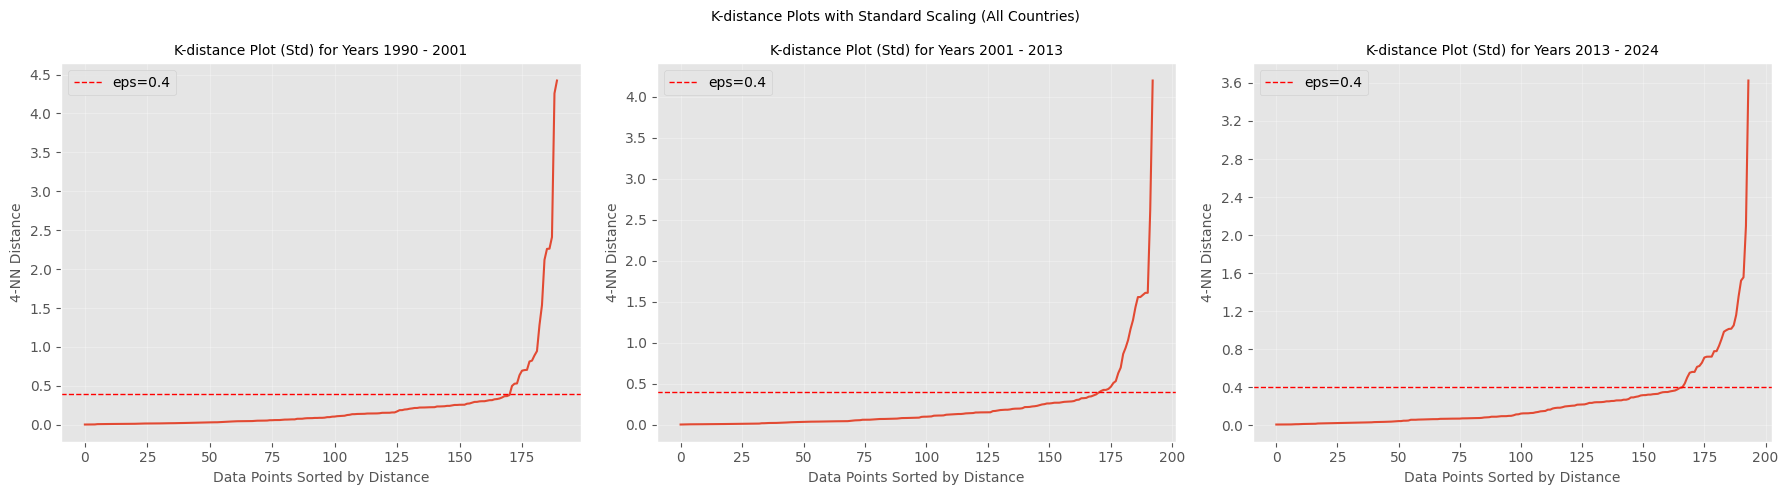

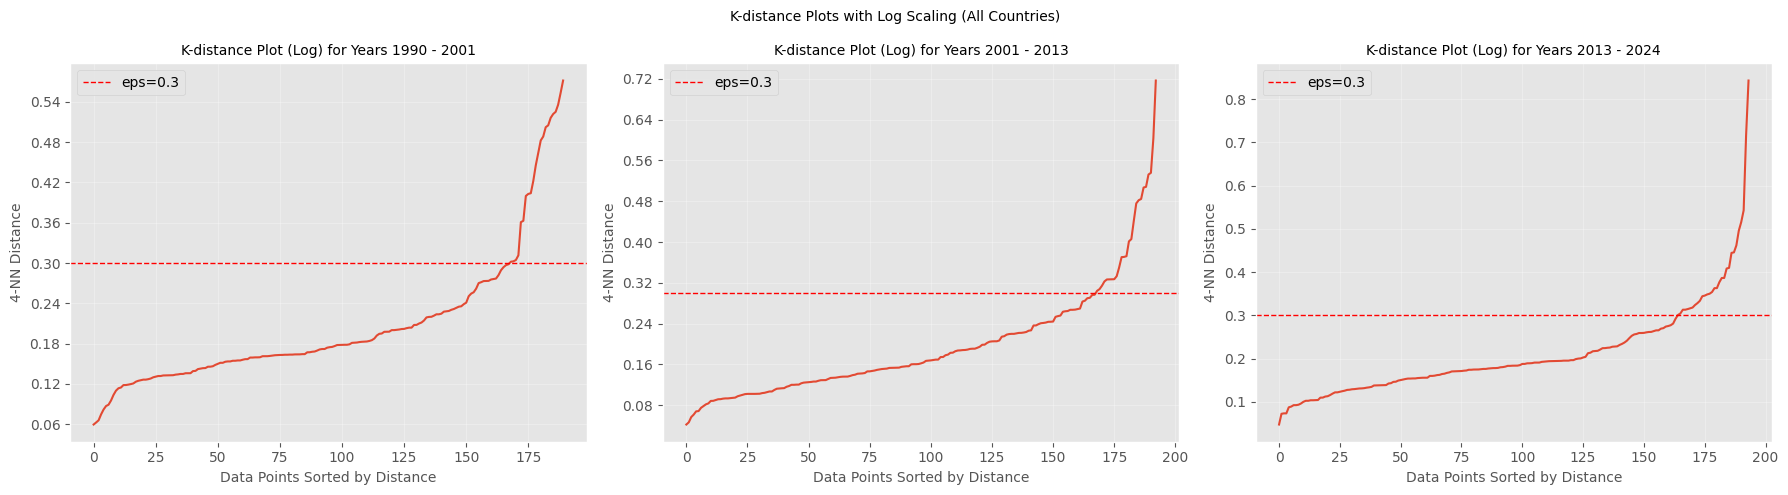

In [5]:
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import MaxNLocator

# K-distance plots for all countries
fig_kd_std, axes_kd_std = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))
fig_kd_log, axes_kd_log = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))

k = 4  # min_samples - 1 for DBSCAN
eps_std = 0.5  # eps value for standard scale
eps_log = 0.5  # eps value for log scale

for i in range(num_ranges):
    # Create subsets
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    df_subset = df[(df['Year'] >= year_start) & (df['Year'] < year_end)]
    df_subset_agg = df_subset.groupby('Country Name').agg({
            'GDP per capita': 'mean', 
            'CO2 emissions per capita': 'mean',
            'log (GDP pc)': 'mean',
            'log (CO2 pc)': 'mean'
        }).reset_index()
    
    # K-distance plot for standard scale
    X_std = df_subset_agg[['GDP per capita', 'CO2 emissions per capita']].values
    scaler = StandardScaler()
    X_std_scaled = scaler.fit_transform(X_std)
    
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_std_scaled)
    distances, indices = nbrs.kneighbors(X_std_scaled)
    distances = np.sort(distances[:, k], axis=0)
    
    axes_kd_std[i].plot(distances)
    axes_kd_std[i].axhline(y=0.4, color='r', linestyle='--', linewidth=1, label=f'eps={0.4}')
    axes_kd_std[i].set_ylabel(f'{k}-NN Distance', fontsize=10)
    axes_kd_std[i].set_xlabel('Data Points Sorted by Distance', fontsize=10)
    axes_kd_std[i].set_title(f'K-distance Plot (Std) for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_kd_std[i].yaxis.set_major_locator(MaxNLocator(nbins=10))
    axes_kd_std[i].legend()
    axes_kd_std[i].grid(True, alpha=0.3)
    
    # K-distance plot for log scale
    X_log = df_subset_agg[['log (GDP pc)', 'log (CO2 pc)']].values
    X_log_scaled = scaler.fit_transform(X_log)
    
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_log_scaled)
    distances, indices = nbrs.kneighbors(X_log_scaled)
    distances = np.sort(distances[:, k], axis=0)
    
    axes_kd_log[i].plot(distances)
    axes_kd_log[i].axhline(y=0.3, color='r', linestyle='--', linewidth=1, label=f'eps={0.3}')
    axes_kd_log[i].set_ylabel(f'{k}-NN Distance', fontsize=10)
    axes_kd_log[i].set_xlabel('Data Points Sorted by Distance', fontsize=10)
    axes_kd_log[i].set_title(f'K-distance Plot (Log) for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_kd_log[i].yaxis.set_major_locator(MaxNLocator(nbins=10))
    axes_kd_log[i].legend()
    axes_kd_log[i].grid(True, alpha=0.3)

fig_kd_std.suptitle('K-distance Plots with Standard Scaling (All Countries)', fontsize=10)
fig_kd_log.suptitle('K-distance Plots with Log Scaling (All Countries)', fontsize=10)
fig_kd_std.tight_layout()
fig_kd_log.tight_layout()
fig_kd_std.savefig(f'../plots/dbscan/kdist_std.png')
fig_kd_log.savefig(f'../plots/dbscan/kdist_log.png')

### 1.1 All countries (2024)

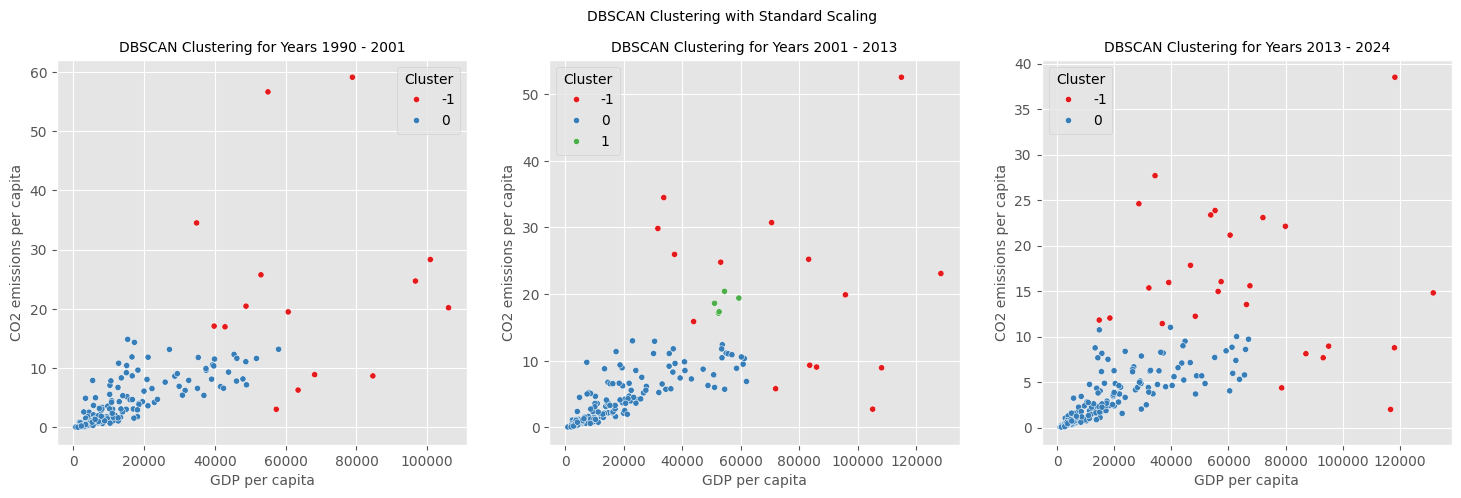

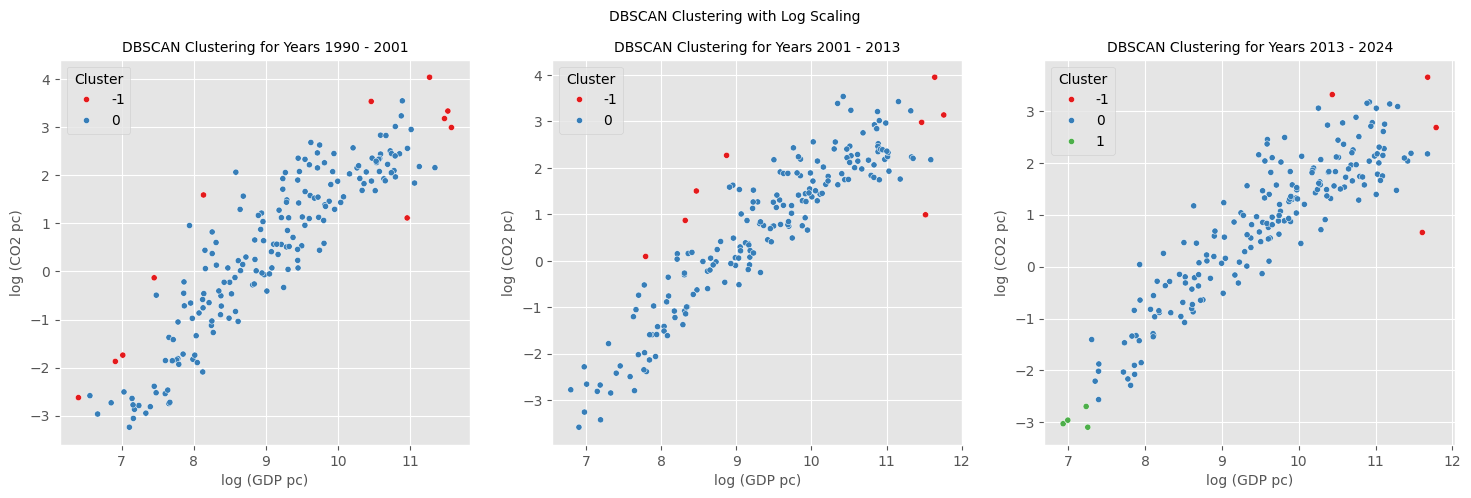

In [10]:
fig_std, axes_std = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))
fig_log, axes_log = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))

df['Cluster (Std)'] = np.nan
df['Cluster (Log)'] = np.nan

for i in range(num_ranges):
    # create subsets
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    df_subset = df[(df['Year'] >= year_start) & (df['Year'] < year_end)]
    df_subset_agg = df_subset.groupby('Country Name').agg({
            'GDP per capita': 'mean', 
            'CO2 emissions per capita': 'mean',
            'log (GDP pc)': 'mean',
            'log (CO2 pc)': 'mean'
        }).reset_index()
    period_label = f"{int(year_start)}-{int(year_end)}"
    
    # ------------------------------ DBSCAN standard scale ------------------------------------
    df_cluster_std = dbscan_clustering(df_subset_agg, ['GDP per capita', 'CO2 emissions per capita'], 
                                               eps=0.4, min_samples=5, results_col_name='Cluster (Std)') 

    sns.scatterplot(data=df_cluster_std, x='GDP per capita', y='CO2 emissions per capita', s=20, 
                       hue='Cluster (Std)', palette='Set1', ax=axes_std[i], legend='brief')
    axes_std[i].set_title(f'DBSCAN Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_std[i].set_xlabel('GDP per capita', fontsize=10)
    axes_std[i].set_ylabel('CO2 emissions per capita', fontsize=10)
    axes_std[i].get_legend().set_title('Cluster')
    
    mask = (df['Year'] >= year_start) & (df['Year'] <= year_end)
    cluster_map_std = df_cluster_std.set_index('Country Name')['Cluster (Std)']
    df.loc[mask, 'Cluster (Std)'] = df.loc[mask, 'Country Name'].map(cluster_map_std)

    # -------------------------------- DBSCAN log scale ------------------------------------
    df_cluster_log = dbscan_clustering(df_subset_agg, ['log (GDP pc)', 'log (CO2 pc)'], 
                                               eps=0.35, min_samples=5, results_col_name='Cluster (Log)') 

    sns.scatterplot(data=df_cluster_log, x='log (GDP pc)', y='log (CO2 pc)', s=20, 
                       hue='Cluster (Log)', palette='Set1', ax=axes_log[i], legend='brief')
    axes_log[i].set_title(f'DBSCAN Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_log[i].set_xlabel('log (GDP pc)', fontsize=10)
    axes_log[i].set_ylabel('log (CO2 pc)', fontsize=10)
    axes_log[i].get_legend().set_title('Cluster')
    
    cluster_map_log = df_cluster_log.set_index('Country Name')['Cluster (Log)']
    df.loc[mask, 'Cluster (Log)'] = df.loc[mask, 'Country Name'].map(cluster_map_log)
    
fig_std.suptitle('DBSCAN Clustering with Standard Scaling', fontsize=10)
fig_log.suptitle('DBSCAN Clustering with Log Scaling', fontsize=10)
fig_std.savefig(f'../plots/dbscan/cluster_std.png')
fig_log.savefig(f'../plots/dbscan/cluster_log.png')

### 1.2 Europe

In [11]:
df_europe = df[df['Continent'] == 'Europe']

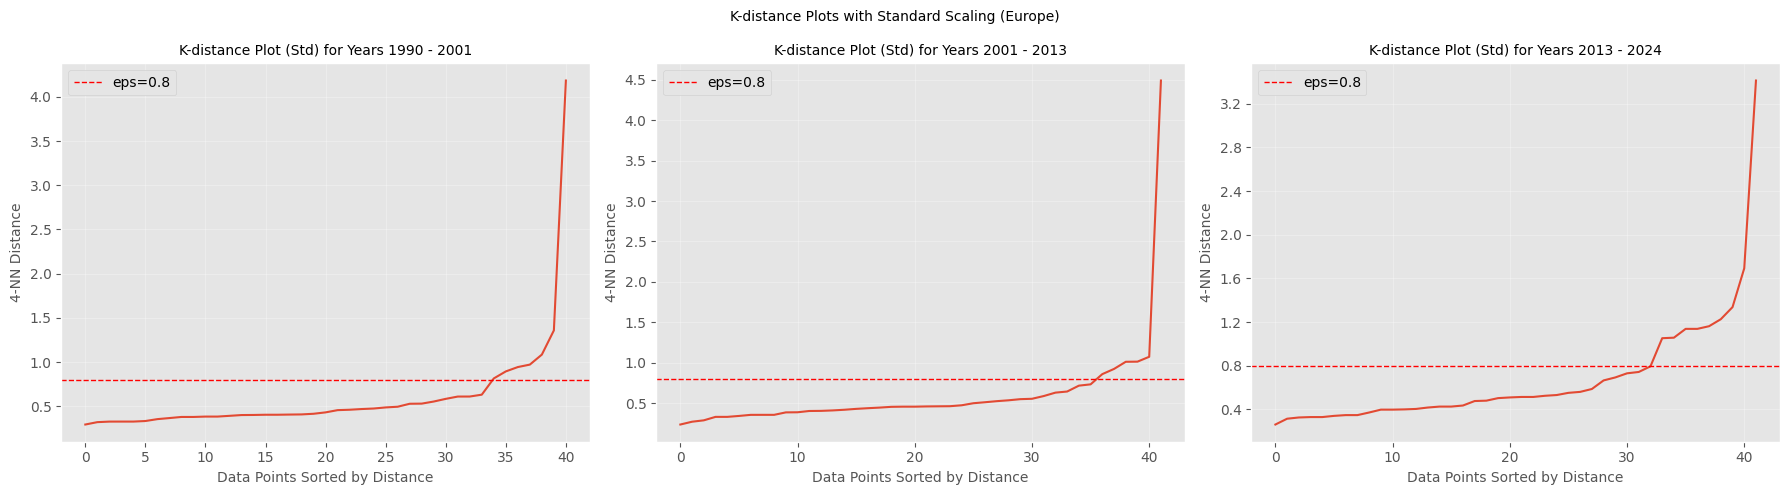

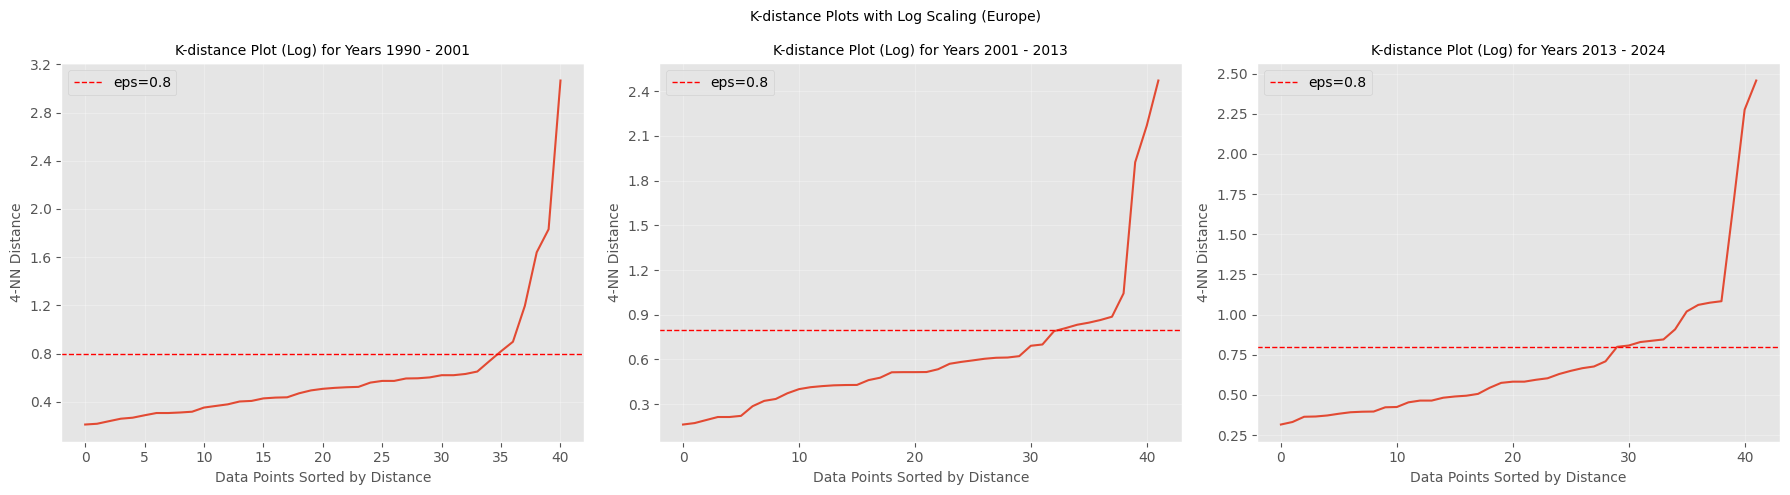

In [13]:
# K-distance plots for all countries
fig_kd_std, axes_kd_std = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))
fig_kd_log, axes_kd_log = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))

k = 4  # min_samples - 1 for DBSCAN
eps_std = 0.8  # eps value for standard scale
eps_log = 0.8  # eps value for log scale

for i in range(num_ranges):
    # Create subsets
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    df_subset = df_europe[(df_europe['Year'] >= year_start) & (df_europe['Year'] < year_end)]
    df_subset_agg = df_subset.groupby('Country Name').agg({
            'GDP per capita': 'mean', 
            'CO2 emissions per capita': 'mean',
            'log (GDP pc)': 'mean',
            'log (CO2 pc)': 'mean'
        }).reset_index()
    
    # K-distance plot for standard scale
    X_std = df_subset_agg[['GDP per capita', 'CO2 emissions per capita']].values
    scaler = StandardScaler()
    X_std_scaled = scaler.fit_transform(X_std)
    
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_std_scaled)
    distances, indices = nbrs.kneighbors(X_std_scaled)
    distances = np.sort(distances[:, k], axis=0)
    
    axes_kd_std[i].plot(distances)
    axes_kd_std[i].axhline(y=eps_std, color='r', linestyle='--', linewidth=1, label=f'eps={eps_std}')
    axes_kd_std[i].set_ylabel(f'{k}-NN Distance', fontsize=10)
    axes_kd_std[i].set_xlabel('Data Points Sorted by Distance', fontsize=10)
    axes_kd_std[i].set_title(f'K-distance Plot (Std) for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_kd_std[i].yaxis.set_major_locator(MaxNLocator(nbins=10))
    axes_kd_std[i].legend()
    axes_kd_std[i].grid(True, alpha=0.3)
    
    # K-distance plot for log scale
    X_log = df_subset_agg[['log (GDP pc)', 'log (CO2 pc)']].values
    X_log_scaled = scaler.fit_transform(X_log)
    
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_log_scaled)
    distances, indices = nbrs.kneighbors(X_log_scaled)
    distances = np.sort(distances[:, k], axis=0)
    
    axes_kd_log[i].plot(distances)
    axes_kd_log[i].axhline(y=eps_log, color='r', linestyle='--', linewidth=1, label=f'eps={eps_log}')
    axes_kd_log[i].set_ylabel(f'{k}-NN Distance', fontsize=10)
    axes_kd_log[i].set_xlabel('Data Points Sorted by Distance', fontsize=10)
    axes_kd_log[i].set_title(f'K-distance Plot (Log) for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_kd_log[i].yaxis.set_major_locator(MaxNLocator(nbins=10))
    axes_kd_log[i].legend()
    axes_kd_log[i].grid(True, alpha=0.3)

fig_kd_std.suptitle('K-distance Plots with Standard Scaling (Europe)', fontsize=10)
fig_kd_log.suptitle('K-distance Plots with Log Scaling (Europe)', fontsize=10)
fig_kd_std.tight_layout()
fig_kd_log.tight_layout()
fig_kd_std.savefig(f'../plots/dbscan/kdist_std_europe.png')
fig_kd_log.savefig(f'../plots/dbscan/kdist_log_europe.png')

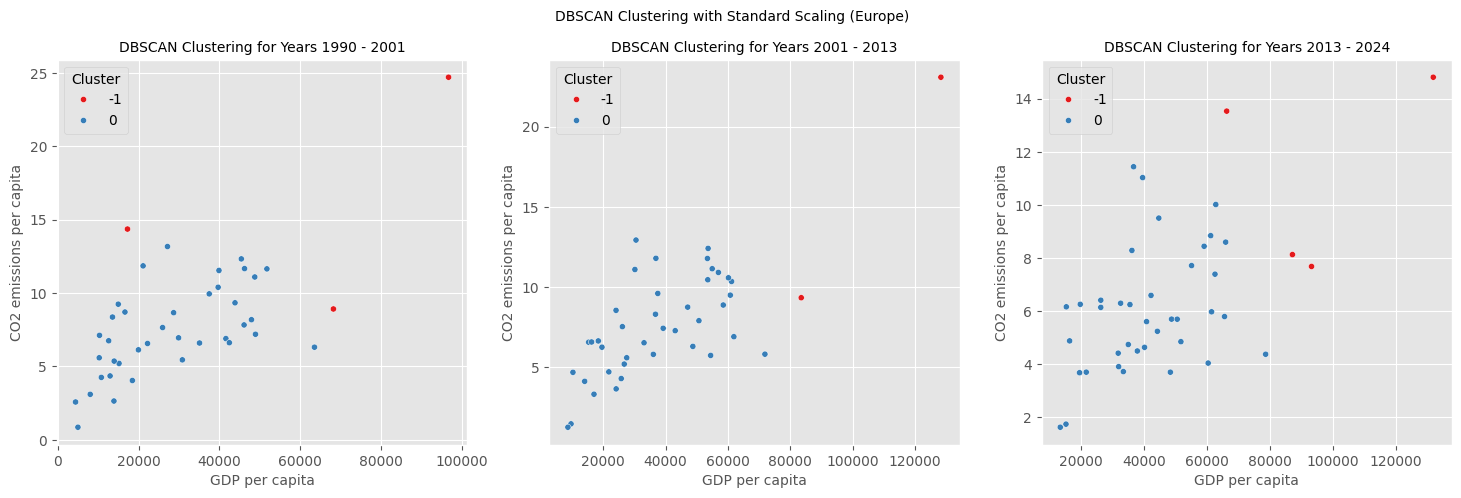

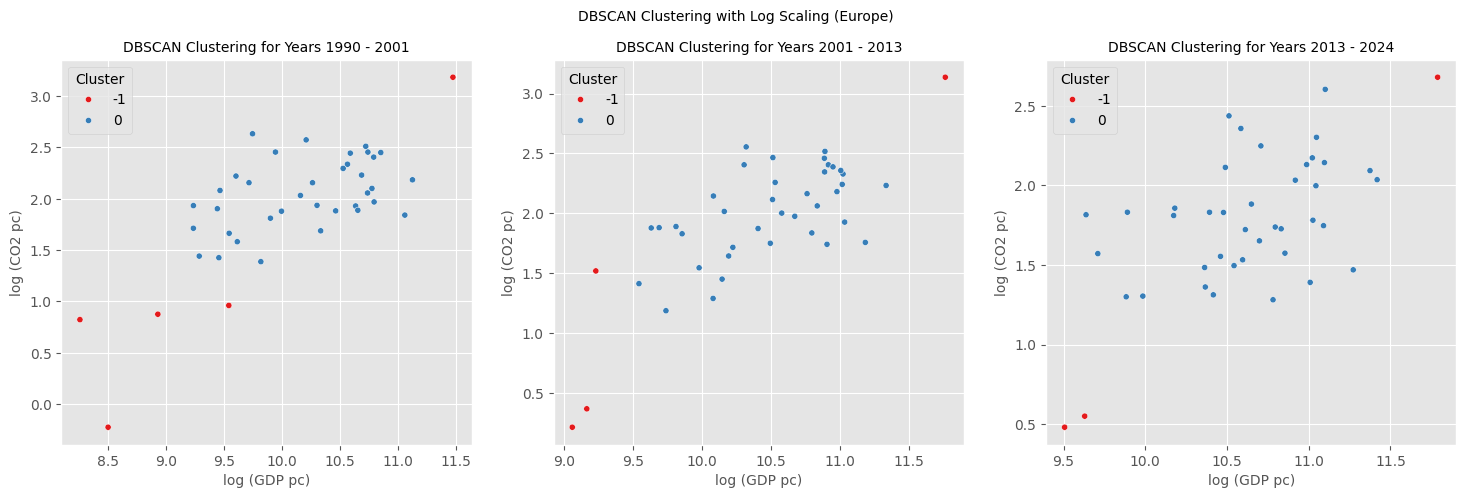

In [14]:
fig_std, axes_std = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))
fig_log, axes_log = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))

df_europe['Cluster (Std)'] = np.nan
df_europe['Cluster (Log)'] = np.nan

for i in range(num_ranges):
    # create subsets
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    df_subset = df_europe[(df_europe['Year'] >= year_start) & (df_europe['Year'] < year_end)]
    df_subset_agg = df_subset.groupby('Country Name').agg({
            'GDP per capita': 'mean', 
            'CO2 emissions per capita': 'mean',
            'log (GDP pc)': 'mean',
            'log (CO2 pc)': 'mean'
        }).reset_index()
    period_label = f"{int(year_start)}-{int(year_end)}"
    
    # ------------------------------ DBSCAN standard scale ------------------------------------
    df_cluster_std = dbscan_clustering(df_subset_agg, ['GDP per capita', 'CO2 emissions per capita'], 
                                               eps=0.8, min_samples=5, results_col_name='Cluster (Std)') 

    sns.scatterplot(data=df_cluster_std, x='GDP per capita', y='CO2 emissions per capita', s=20, 
                       hue='Cluster (Std)', palette='Set1', ax=axes_std[i], legend='brief')
    axes_std[i].set_title(f'DBSCAN Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_std[i].set_xlabel('GDP per capita', fontsize=10)
    axes_std[i].set_ylabel('CO2 emissions per capita', fontsize=10)
    axes_std[i].get_legend().set_title('Cluster')
    
    mask = (df_europe['Year'] >= year_start) & (df_europe['Year'] <= year_end)
    cluster_map_std = df_cluster_std.set_index('Country Name')['Cluster (Std)']
    df_europe.loc[mask, 'Cluster (Std)'] = df_europe.loc[mask, 'Country Name'].map(cluster_map_std)

    # -------------------------------- DBSCAN log scale ------------------------------------
    df_cluster_log = dbscan_clustering(df_subset_agg, ['log (GDP pc)', 'log (CO2 pc)'], 
                                               eps=0.8, min_samples=5, results_col_name='Cluster (Log)') 

    sns.scatterplot(data=df_cluster_log, x='log (GDP pc)', y='log (CO2 pc)', s=20, 
                       hue='Cluster (Log)', palette='Set1', ax=axes_log[i], legend='brief')
    axes_log[i].set_title(f'DBSCAN Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_log[i].set_xlabel('log (GDP pc)', fontsize=10)
    axes_log[i].set_ylabel('log (CO2 pc)', fontsize=10)
    axes_log[i].get_legend().set_title('Cluster')
    
    cluster_map_log = df_cluster_log.set_index('Country Name')['Cluster (Log)']
    df_europe.loc[mask, 'Cluster (Log)'] = df_europe.loc[mask, 'Country Name'].map(cluster_map_log)
    
fig_std.suptitle('DBSCAN Clustering with Standard Scaling (Europe)', fontsize=10)
fig_log.suptitle('DBSCAN Clustering with Log Scaling (Europe)', fontsize=10)
fig_std.savefig(f'../plots/dbscan/cluster_std_europe.png')
fig_log.savefig(f'../plots/dbscan/cluster_log_europe.png')